#### Data Validation, Cleaning & Exploratory Analysis

This notebook demonstrates a realistic quant research support workflow:
- Ingest raw tick data (intentionally noisy, as in production feeds)
- Perform systematic data quality checks
- Clean and validate the dataset
- Conduct exploratory analysis relevant to quantitative research (distributions, correlations, regime detection, etc.)

Built with Pandas and NumPy — clean, readable, efficient code suitable for internal tools and collaboration with researchers.

The dataset is a synthetic but highly realistic tick-level BTCUSDT feed with common real-world issues: missing values, outliers, negative prices, duplicates, zero volumes.

#### 1: Imports and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For better plot styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the synthetic raw data
df_raw = pd.read_csv('synthetic_tick_data.csv', parse_dates=['timestamp'])

print("Raw data loaded successfully.")
print(f"Shape: {df_raw.shape}")
df_raw.head()

Raw data loaded successfully.
Shape: (20050, 5)


,timestamp,symbol,exchange,price,volume
0,2025-06-14 23:59:59.874540119,BTCUSDT,Binance,60000.00,7007.0
1,2025-06-15 00:00:04.770714306,BTCUSDT,Binance,60000.02,3756.0
2,2025-06-15 00:00:08.871993942,BTCUSDT,Binance,60000.07,6784.0
3,2025-06-15 00:00:13.058658484,BTCUSDT,Binance,60000.03,3287.0
4,2025-06-15 00:00:16.936018640,BTCUSDT,Binance,60000.09,1082.0


#### 2: Initial Overview and Data Types

In [3]:
print("Data types and memory usage:")
print(df_raw.info())

print("\nSample of first 10 rows:")
display(df_raw.head(10))

print("\nBasic statistics (numeric + object + datetime columns):")
# Use include='all' to get stats for all columns
# Modern Pandas automatically includes datetime stats (count, min, max, etc.)
display(df_raw.describe(include='all'))

Data types and memory usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  20050 non-null  datetime64[ns]
 1   symbol     20050 non-null  object        
 2   exchange   20050 non-null  object        
 3   price      19949 non-null  float64       
 4   volume     19951 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 783.3+ KB
None

Sample of first 10 rows:


,timestamp,symbol,exchange,price,volume
0,2025-06-14 23:59:59.874540119,BTCUSDT,Binance,60000.00,7007.0
1,2025-06-15 00:00:04.770714306,BTCUSDT,Binance,60000.02,3756.0
2,2025-06-15 00:00:08.871993942,BTCUSDT,Binance,60000.07,6784.0
3,2025-06-15 00:00:13.058658484,BTCUSDT,Binance,60000.03,3287.0
4,2025-06-15 00:00:16.936018640,BTCUSDT,Binance,60000.09,1082.0
5,2025-06-15 00:00:21.255994520,BTCUSDT,Binance,60000.09,559.0
6,2025-06-15 00:00:25.478083612,BTCUSDT,Binance,60000.05,2009.0
7,2025-06-15 00:00:30.606176146,BTCUSDT,Binance,60000.08,944.0
8,2025-06-15 00:00:34.661115012,BTCUSDT,Binance,60000.06,2491.0
9,2025-06-15 00:00:39.088072578,BTCUSDT,Binance,60000.06,1425.0



Basic statistics (numeric + object + datetime columns):


,timestamp,symbol,exchange,price,volume
count,20050,20050,20050,1.994900e+04,19951.000000
unique,NaN,1,1,NaN,NaN
top,NaN,BTCUSDT,Binance,NaN,NaN
freq,NaN,20050,20050,NaN,NaN
mean,2025-06-15 12:00:02.763286272,NaN,NaN,6.421181e+04,8805.766478
min,2025-06-14 23:59:59.874540119,NaN,NaN,-6.000385e+04,0.000000
25%,2025-06-15 06:00:09.945911808,NaN,NaN,5.999959e+04,1022.000000
50%,2025-06-15 11:59:49.372097792,NaN,NaN,6.000132e+04,2915.000000
75%,2025-06-15 18:00:07.668686848,NaN,NaN,6.000271e+04,8086.500000
max,2025-06-15 23:59:55.352264814,NaN,NaN,6.000421e+06,820832.000000


#### 3: Comprehensive Data Quality Report

In [4]:
print("="*60)
print("DATA QUALITY REPORT")
print("="*60)

# 1. Duplicates
duplicates = df_raw.duplicated(subset=['timestamp']).sum()
print(f"Duplicate timestamps: {duplicates:,} ({duplicates/len(df_raw)*100:.2f}%)")

# 2. Missing values
missing = df_raw.isnull().sum()
print(f"\nMissing values:")
for col, cnt in missing.items():
    if cnt > 0:
        print(f"  {col}: {cnt:,} ({cnt/len(df_raw)*100:.2f}%)")

# 3. Negative prices
neg_prices = (df_raw['price'] < 0).sum()
print(f"\nNegative prices: {neg_prices:,}")

# 4. Zero volumes
zero_vol = (df_raw['volume'] == 0).sum()
print(f"Zero volume ticks: {zero_vol:,} ({zero_vol/len(df_raw)*100:.2f}%)")

# 5. Extreme outliers (using simple price threshold, e.g., > 5x median)
median_price = df_raw['price'].median()
extreme_high = (df_raw['price'] > 5 * median_price).sum()
print(f"Extreme price outliers (>5x median): {extreme_high:,}")

# 6. Timestamp issues
df_raw_sorted = df_raw.sort_values('timestamp')
gaps = (df_raw_sorted['timestamp'].diff().dt.total_seconds() > 10)  # >10s gap
large_gaps = gaps.sum()
print(f"Large timestamp gaps (>10 seconds): {large_gaps:,}")

# Overall health
print(f"\nOverall data completeness: {((df_raw[['price', 'volume']].notna()).all(axis=1).sum() / len(df_raw) * 100):.2f}% clean rows")

DATA QUALITY REPORT
Duplicate timestamps: 50 (0.25%)

Missing values:
  price: 101 (0.50%)
  volume: 99 (0.49%)

Negative prices: 20
Zero volume ticks: 400 (2.00%)
Extreme price outliers (>5x median): 20
Large timestamp gaps (>10 seconds): 0

Overall data completeness: 99.50% clean rows


#### 4: Cleaning Pipeline (Create Cleaned Version)

##### Step 1: Sort by timestamp

In [6]:
df = df_raw.copy()

df = df.sort_values('timestamp').reset_index(drop=True)

##### Step 2: Remove exact duplicates

In [7]:
print(f"Before deduplication: {len(df)} rows")
df = df.drop_duplicates(subset=['timestamp'], keep='first')
print(f"After deduplication: {len(df)} rows")

Before deduplication: 20050 rows
After deduplication: 20000 rows


##### Step 3: Handle negative prices (likely encoding errors → set to NaN)

In [8]:
neg_count = (df['price'] < 0).sum()
df.loc[df['price'] < 0, 'price'] = np.nan
print(f"Negative prices converted to NaN: {neg_count}")

Negative prices converted to NaN: 20


##### Step 4: Remove extreme outliers

In [9]:
upper_bound = 10 * df['price'].median()
outlier_count = (df['price'] > upper_bound).sum()
df.loc[df['price'] > upper_bound, 'price'] = np.nan
print(f"Extreme outliers (>10x median) set to NaN: {outlier_count}")


Extreme outliers (>10x median) set to NaN: 17


##### Step 5: Forward-fill small missing gaps (common in tick data)

In [10]:
# Only fill if gap is small and we have context
df['price_ffill'] = df['price'].ffill()
df['volume_ffill'] = df['volume'].ffill()

In [11]:
# For research, often better to drop rows with missing price
df_clean = df.dropna(subset=['price']).copy()
df_clean['volume'] = df_clean['volume'].fillna(0)  # Volume 0 is meaningful


In [12]:
print(f"\nFinal cleaned dataset: {len(df_clean):,} rows ({len(df_clean)/len(df_raw)*100:.1f}% retained)")


Final cleaned dataset: 19,863 rows (99.1% retained)


#### 5: Exploratory Analysis – Price and Returns

In [13]:
df = df_clean.copy()  # Work with cleaned data

# Compute log returns (standard in quant research)
df['log_return'] = np.log(df['price'] / df['price'].shift(1))

# Basic return stats
print("Log Return Statistics:")
print(df['log_return'].describe())

Log Return Statistics:
count    1.986200e+04
mean    -3.935642e-09
std      4.002125e-02
min     -2.302585e+00
25%     -4.999758e-07
50%      0.000000e+00
75%      4.999721e-07
max      2.302585e+00
Name: log_return, dtype: float64


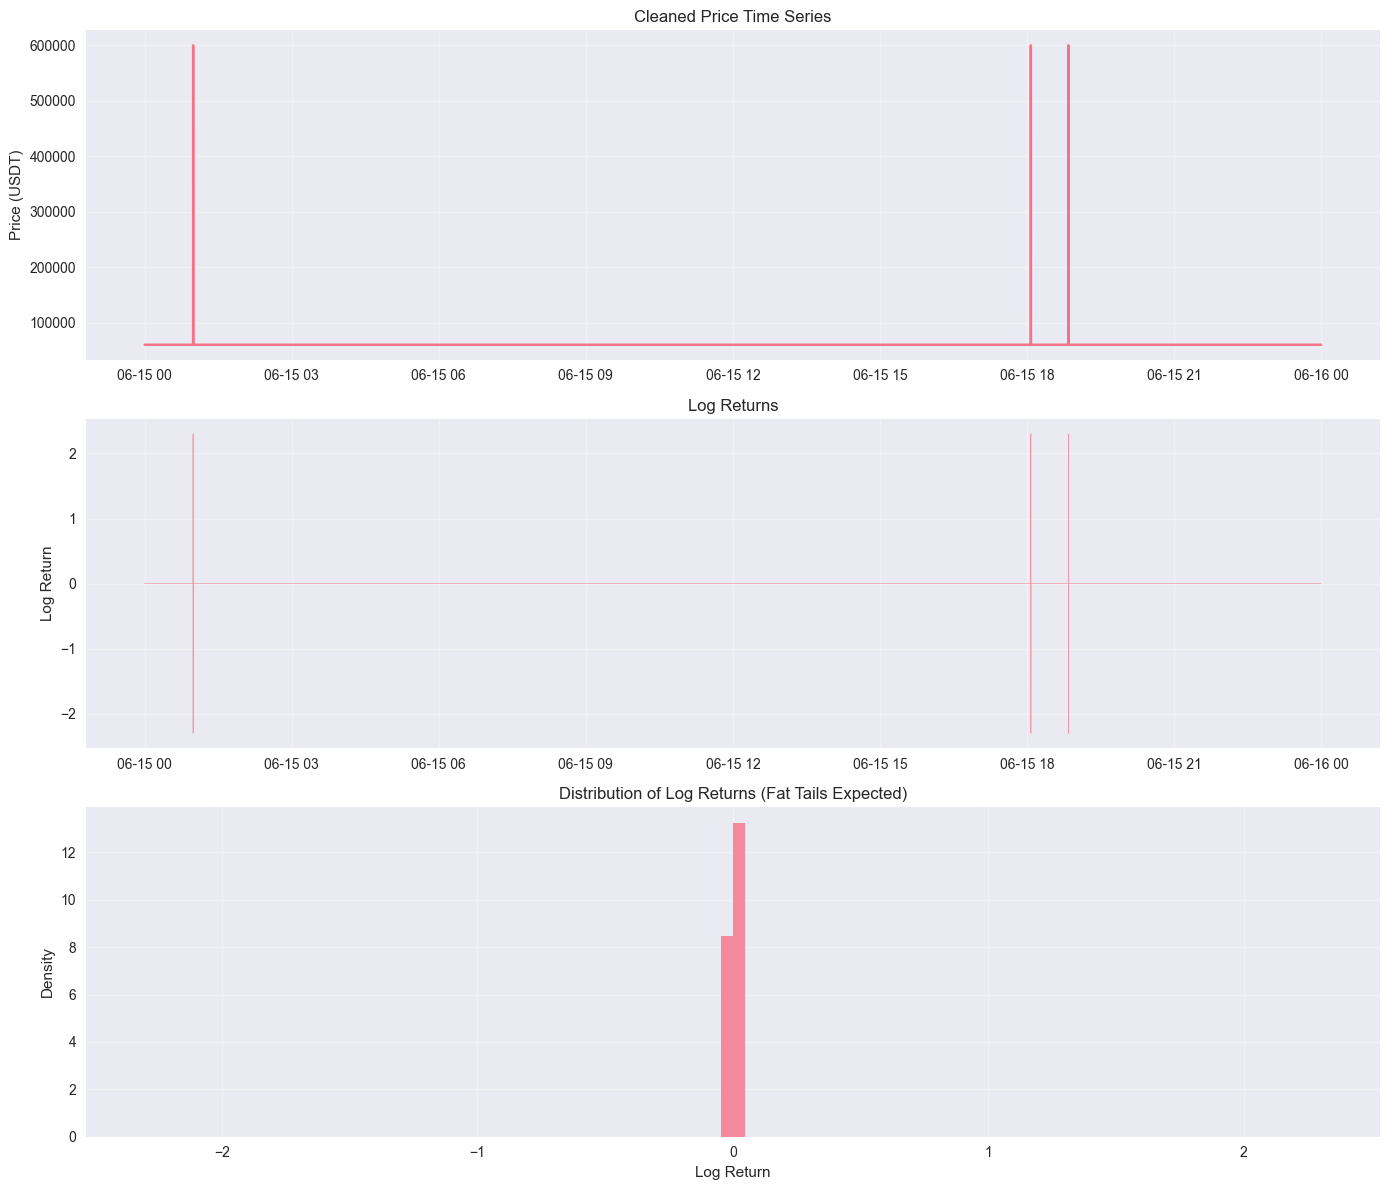

In [14]:
# Plot price and returns
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Price over time
axes[0].plot(df['timestamp'], df['price'])
axes[0].set_title('Cleaned Price Time Series')
axes[0].set_ylabel('Price (USDT)')
axes[0].grid(True, alpha=0.3)

# Returns
axes[1].plot(df['timestamp'], df['log_return'], alpha=0.7, linewidth=0.5)
axes[1].set_title('Log Returns')
axes[1].set_ylabel('Log Return')
axes[1].grid(True, alpha=0.3)

# Return distribution
axes[2].hist(df['log_return'].dropna(), bins=100, alpha=0.8, density=True)
axes[2].set_title('Distribution of Log Returns (Fat Tails Expected)')
axes[2].set_xlabel('Log Return')
axes[2].set_ylabel('Density')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 6: Advanced Exploration – Rolling Statistics & Correlations

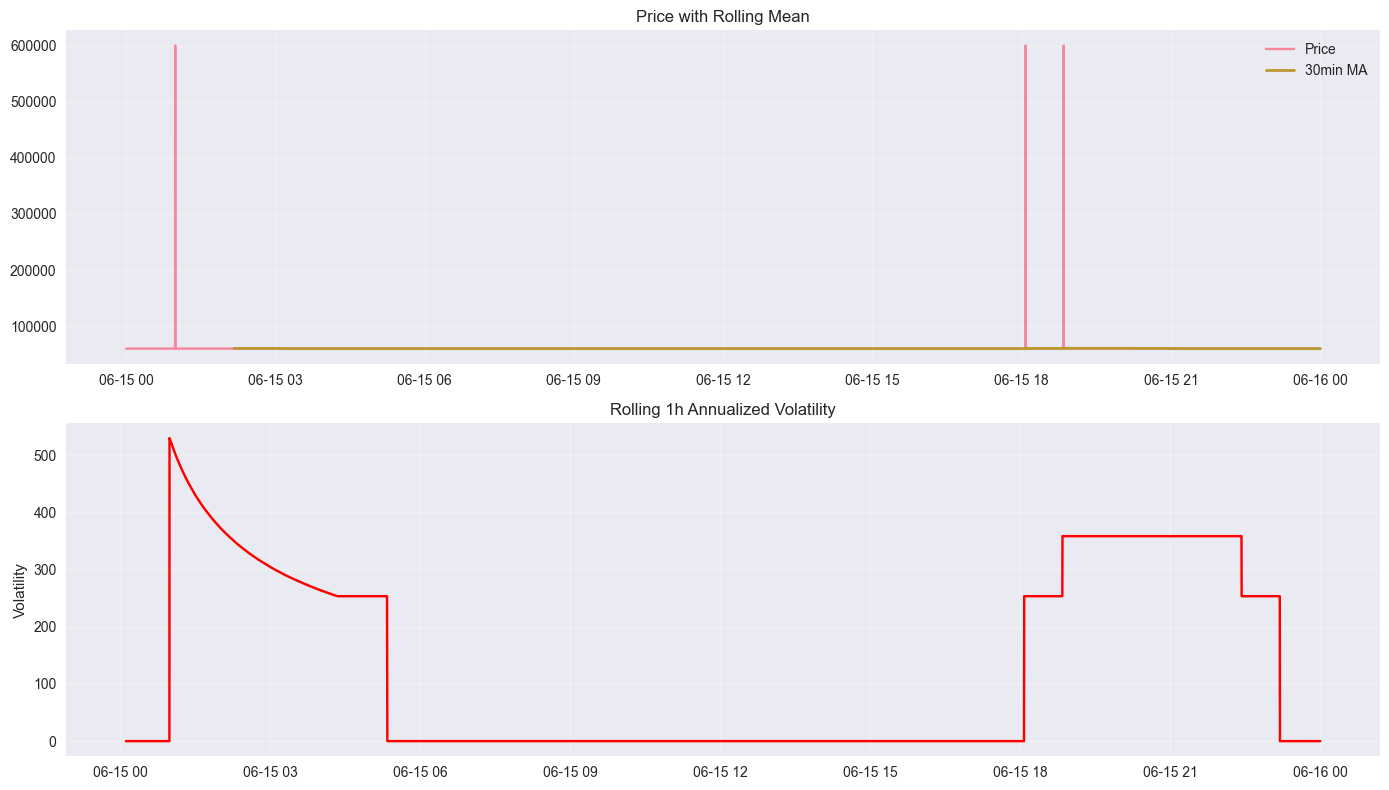

In [15]:
df['rolling_vol_1h'] = df['log_return'].rolling(window=3600, min_periods=100).std() * np.sqrt(252*24*3600)  # Annualized
df['rolling_mean'] = df['price'].rolling(window=1800).mean()  # ~30min MA

fig, ax = plt.subplots(2, 1, figsize=(14, 8))

ax[0].plot(df['timestamp'], df['price'], label='Price', alpha=0.8)
ax[0].plot(df['timestamp'], df['rolling_mean'], label='30min MA', linewidth=2)
ax[0].set_title('Price with Rolling Mean')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].plot(df['timestamp'], df['rolling_vol_1h'], color='red')
ax[1].set_title('Rolling 1h Annualized Volatility')
ax[1].set_ylabel('Volatility')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()